# QAOA Weighted MAXSAT

Gahwon Lee, Andrew Tan

In [1]:
import qiskit
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Introduction

### Weighted MAXSAT (3-SAT)

Given a boolean formula in conjunctive normal form as well as weights to each of those clauses, find the set of boolean variables that maximize the weights. For example, if a clause with weight 3 is true, then add 3 to the total weight. Each clause can contain exactly three boolean variables.

### QAOA

Quantum Approximation Optimization Algorithm is designed to approximate the Quantum Adiabatic Algorithm by splitting up different time slices into separate gates. Since it approximates the QAA, as the number of gates increases to infinity, the QAOA result will also increase to the ideal state.

## Methods

### Encoding Qubits

The bitstring corresponding to the output of QAOA will be the input qubits. Each qubit will either be 1 for true or 0 for false. 

### Cost and Driver Hamiltonians *C* and *B*

(3-SAT) $C = \sum_{m=0}^M I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2)\otimes (I_3 \pm Z_3))$

(2-SAT) $C = \sum_{m=0}^M I-\frac{1}{2}((I_1 \pm Z_1)\otimes (I_2 \pm Z_2))$

$B = \sum_{k=0}^{n-1} X_k$

### Driver Gate W

$W(\beta) = \mul_{k=1}^n H_k

In [2]:
def ref_gate(n, qc, q, beta):
    # W gate
    for i in range(0,n):
        qc.h(q[i])
    for i in range(1,n):
        qc.cx(q[i],q[0])
        
    # apply phase gate
    qc.u1(2*beta, q[0])
    
    for i in range(n-1,0,-1):
        qc.cx(q[i],q[0])
    for i in range(0,n):
        qc.h(q[i])

### Cost Gate V

$V(\gamma) = ...

In [3]:
def constraint_gate(n, qc, q, gamma, clauses):
    # V gate
    # 2-SAT
    
    # clause[0] is the weight
    # clauses will be in form clauses[i] = [-1*x,y] with x and y refering to the qubits we act on, and a negative value
    # means a NOT-x
    # clauses are also 1-indexed, so be sure to subtract by 1 before reading them!
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        
        flip = 2*(x_not == y_not) - 1 # flips if x_not xor y_not
        qc.cx(q[x],q[y])
        qc.u1(flip*-1*gamma*weight,q[y])
        qc.cx(q[x],q[y])

        flip = -(2*(x_not)-1) # x
        qc.u1(flip*-1*gamma*weight,q[x])

        flip = -(2*(y_not)-1) # y
        qc.u1(flip*-1*gamma*weight,q[y])

### Classic Solver

In [4]:
def classic(clauses, value):
    value = value[::-1]
    res = 0
    
    for clause in clauses:
        weight = clause[0]
        x = abs(clause[1]) - 1
        x_not = clause[1] < 0
        # see if the x boolean is a NOT-x
        y = abs(clause[2]) - 1
        y_not = clause[2] < 0
        
        result = ((value[x] == '1') != x_not) or ((value[y] == '1') != y_not)
        if (result):
            res += weight
            
    return res

### Calculating the Expectation
Expectation = <gamma,beta|C|gamma,beta>

In [5]:
def expectation(gamma, beta, clauses):
    n = 3
    q = qiskit.QuantumRegister(n)
    c = qiskit.ClassicalRegister(n)
    qc = qiskit.QuantumCircuit(q,c)
    # q[0..n-1] are input qubits
    for i in range(n):
        qc.h(q[i])
    p = 1
    for pp in range(p):
        constraint_gate(n, qc, q, gamma, clauses)
        ref_gate(n, qc, q, beta)
    
    qc.measure(q, c)
    
    repetitions = 1024
    job = qiskit.execute(qc, backend='local_qasm_simulator', shots=repetitions)
    result = job.result().get_counts(qc)
    
    answer = 0
    for key in result.keys():
        probability = result[key] / repetitions
        answer += probability * classic(clauses, key)
        
    
    return answer
    print("Results: "+str(result));
print("Expectation: "+str(expectation(math.pi/6,math.pi/2, [[1,1,2],[2,-1,-2],[1,-1,2],[2,1,-2]])))

Expectation: 4.5146484375


### Classically Optimizing *γ* and *β*

In [16]:
def targetFunc(params):
    gamma, beta = params
    clauses = [[0,0,0],[0,0,1],[0,1,0]]
    return -qaoa(gamma, beta, clauses)

from scipy.optimize import minimize

x0 = np.array([1.3, 0.7])
res = minimize(targetFunc, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True})

### Plotting

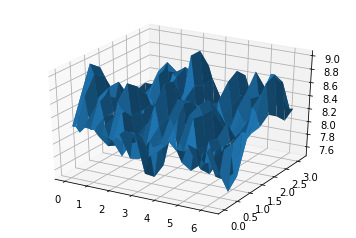

In [9]:
g = np.linspace(0, 2 * math.pi, 40)
b = np.linspace(0, math.pi, 10)
gamma, beta = np.meshgrid(g, b)

def f(x):
    return expectation(x, math.pi/3, [[1,1,2],[1,-1,-2]])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(gamma, beta, np.array([expectation(x, y, [[1,1,3],[2,-1,-2],[2,1,-3],[1,-3,-2],[3,1,-3],[2,-1,3]]) for x,y in zip(np.ravel(gamma), np.ravel(beta))]).reshape(gamma.shape))

#plt.xlabel('gamma')
#plt.ylabel('expectation')
#plt.title('Effect of gamma on QAOA Weighted 2-SAT')
plt.show()

## Results and Discussion

### Generate the following figures, and interpret them.  Make sure to include error bars.

blah

### For several random problem instances, plot the cost of the output state.

#### Plot average, maximum and minimum cost.  How do these compare?

blah

### Fix all parameters except one, and plot cost as a function of the free parameter.

#### Will a classical optimizer always find the best solution?

blah

## Conclusion

### Was QAOA effective in finding decent solutions?

no

### What % of the optimum solution did QAOA achieve?

0%

### Does the technique have any issues?

maybe